In [2]:
import library as lib

C:\Users\doanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input_path = r"C:\phantichdulieu\GSE282701\GSE282701_RAW"
output_path = lib.os.path.join(lib.os.getcwd(), input_path.split('\\')[-2] + '_output')
if not lib.os.path.exists(output_path):
    lib.os.mkdir(output_path)

In [4]:
#Load and merge data
base_path = input_path

# Get a list of all sample directories (010P, 010T, ...)
sample_dirs = [d for d in lib.os.listdir(base_path) if lib.os.path.isdir(lib.os.path.join(base_path, d))]

adata_list = []
print(f"Loading {len(sample_dirs)} samples...")

i = 0
for sample_id in sample_dirs:
    sample_path = lib.os.path.join(base_path, sample_id)
    adata_sample = lib.sc.read_10x_mtx(sample_path, cache=True)
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample'] = sample_id
    if sample_id.endswith('T'):
        adata_sample.obs['group'] = 'Tumor'
    else:
        adata_sample.obs['group'] = 'Para'
    adata_list.append(adata_sample)

    i += 1
    print("Sample list ", i, ": ", sample_id)

adata = lib.ad.concat(adata_list, label = "batch", index_unique = "-")
print("All samples merged:")
print(adata)
print(adata.obs['group'].value_counts())

Loading 12 samples...
Sample list  1 :  010P
Sample list  1 :  010P
Sample list  2 :  010T
Sample list  2 :  010T
Sample list  3 :  011P
Sample list  3 :  011P
Sample list  4 :  011T
Sample list  4 :  011T
Sample list  5 :  012P
Sample list  5 :  012P
Sample list  6 :  012T
Sample list  6 :  012T
Sample list  7 :  013P
Sample list  7 :  013P
Sample list  8 :  013T
Sample list  8 :  013T
Sample list  9 :  014P
Sample list  9 :  014P
Sample list  10 :  014T
Sample list  10 :  014T
Sample list  11 :  015P
Sample list  11 :  015P
Sample list  12 :  015T
Sample list  12 :  015T
All samples merged:
AnnData object with n_obs × n_vars = 141842 × 36591
    obs: 'sample', 'group', 'batch'
group
Tumor    76043
Para     65799
Name: count, dtype: int64
All samples merged:
AnnData object with n_obs × n_vars = 141842 × 36591
    obs: 'sample', 'group', 'batch'
group
Tumor    76043
Para     65799
Name: count, dtype: int64


In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [6]:
lib.sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt", "ribo", "hb"], inplace = True, log1p = True)

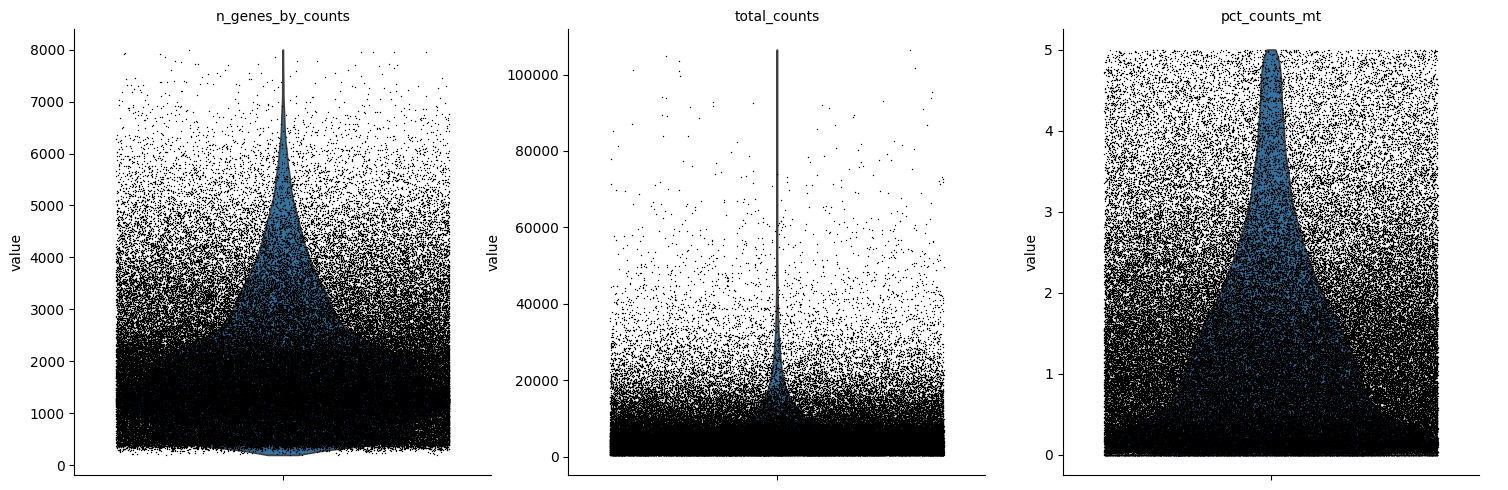

In [ ]:
lib.sc.settings.figdir = output_path

lib.sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save = '.png'
)

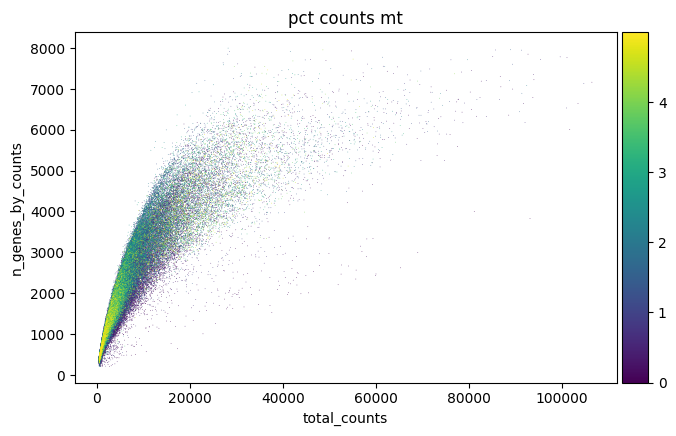

In [ ]:

lib.sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save = ".png" )

In [7]:
lib.sc.pp.filter_cells(adata, min_genes=200)
lib.sc.pp.filter_cells(adata, max_genes=8000)
lib.sc.pp.filter_genes(adata, min_cells=3) #genes that are detected in less than 3 cells.
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
#lib.sc.pp.scrublet(adata, batch_key="sample") #cân nhắc vì chạy tốn time

In [8]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

C:\Users\doanl\AppData\Local\Temp\ipykernel_18040\2262359327.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [9]:
# Normalizing to median total counts
lib.sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
lib.sc.pp.log1p(adata)

In [ ]:
lib.sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
lib.sc.tl.pca(adata, svd_solver='arpack', use_highly_variable = True)

lib.sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 30 , save = ".png") # visualize PCA variance explained

C:\Users\doanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scanpy\preprocessing\_pca\__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [11]:
lib.sc.pp.neighbors(adata)
lib.sc.tl.umap(adata)

In [12]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster,
# especially for larger datasets
lib.sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
lib.sc.pl.umap(adata, color=["leiden"], save = ".png")

categories: 0, 1, 2, etc.
var_group_labels: T/NK, B-cell, Myeloid, etc.
categories: 0, 1, 2, etc.
var_group_labels: T/NK, B-cell, Myeloid, etc.


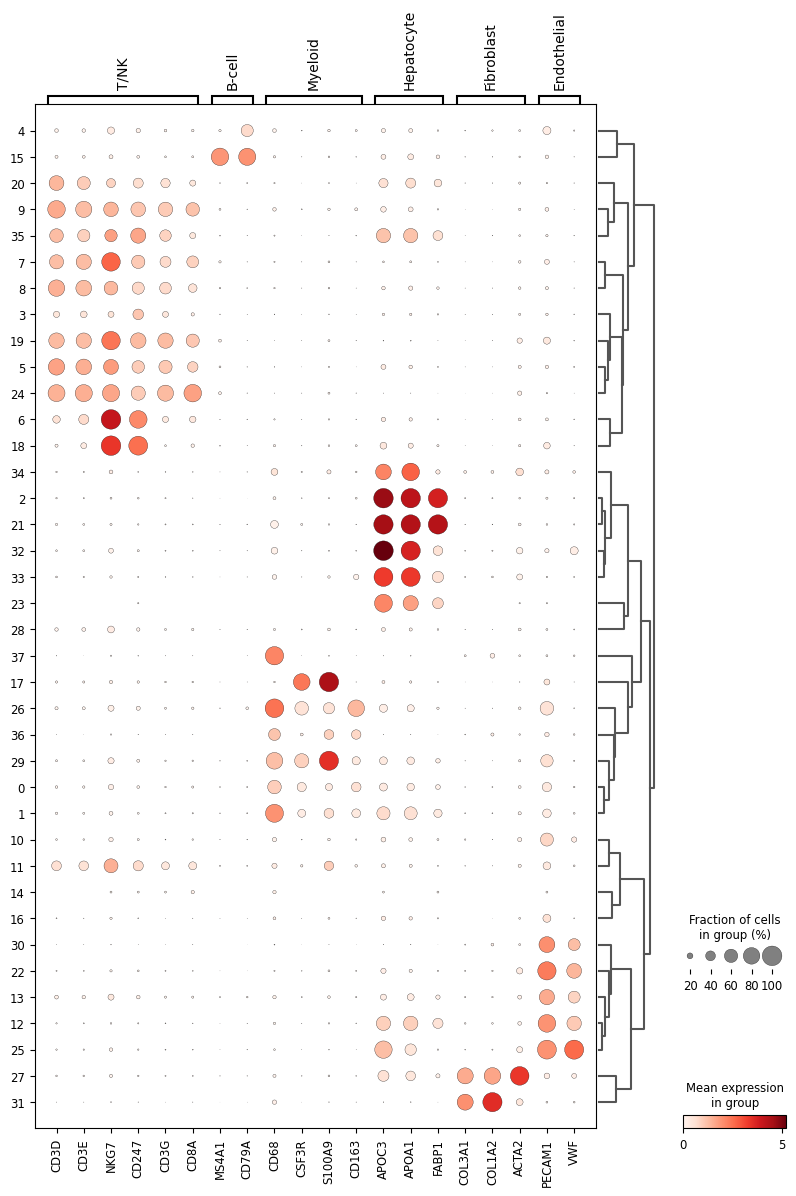

In [13]:
markers = {
    'T/NK': ['CD3D', 'CD3E', 'NKG7','CD247','CD3G','CD8A'],
    'B-cell': ['MS4A1', 'CD79A',],
    'Myeloid': ['CD68', 'CSF3R','S100A9','CD163'],
    'Hepatocyte': ['APOC3', 'APOA1','FABP1'],
    'Fibroblast': ['COL3A1', 'COL1A2', 'ACTA2'],
    'Endothelial': ['PECAM1', 'VWF']
}

# 2. Vẽ DotPlot
# Biểu đồ này sẽ cho bạn thấy 28 cụm (trục Y) biểu hiện các gen này
lib.sc.pl.dotplot(adata,
              markers,
              groupby='leiden',
              dendrogram=True, # Tự động nhóm các cụm giống nhau
              save="_markers.png")

cell_type
Unknown    80731
T/NK       43724
Name: count, dtype: int64


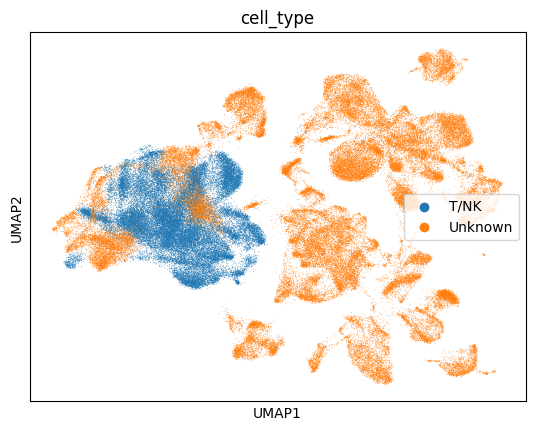

In [14]:
leiden_to_celltype = {
    '20': 'T/NK',
    '9': 'T/NK',
    '35': 'T/NK',
    '7': 'T/NK',
    '8': 'T/NK',
    '19': 'T/NK',
    '5': 'T/NK',
    '24': 'T/NK',
    
}

adata.obs['cell_type'] = adata.obs['leiden'].map(leiden_to_celltype)
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Unknown').astype('category')
print(adata.obs['cell_type'].value_counts())

lib.sc.pl.umap(adata, color='cell_type', legend_loc='right', save="_celltypes.png")

In [16]:
gene_order_path = r"C:\Users\doanl\Downloads\gene_ordering_file.txt"
gene_order_df = (
    lib.pd.read_csv(
        gene_order_path, sep="\t", header=None,
        names=["gene_name", "chromosome", "start", "end"]
    )
    .drop_duplicates("gene_name")
    .set_index("gene_name")
)

adata.var[["chromosome", "start", "end"]] = gene_order_df.reindex(adata.var.index)


In [17]:
adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,chromosome,start,end
MIR1302-2HG,False,False,False,7,0.000049,0.000049,99.995065,7.0,2.079442,7,False,0.000062,0.144763,-0.568047,0,False,chr1,29554,31109
AL627309.1,False,False,False,1190,0.008989,0.008949,99.161038,1275.0,7.151485,1187,False,0.015959,1.530700,0.500201,2,False,chr1,89295,133723
AL627309.2,False,False,False,4,0.000028,0.000028,99.997180,4.0,1.609438,4,False,0.000049,0.135413,-0.229895,0,False,chr1,139790,140339
AL627309.5,False,False,False,837,0.006105,0.006087,99.409907,866.0,6.765039,833,True,0.016517,1.900859,1.031427,5,False,chr1,141474,173862
AP006222.2,False,False,False,228,0.002390,0.002387,99.839258,339.0,5.828946,227,False,0.002501,1.056057,-0.202197,1,False,chr1,266855,268655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC136352.3,False,False,False,8,0.000056,0.000056,99.994360,8.0,2.197225,8,False,0.000052,-0.110259,-0.956016,0,False,KI270727.1,100123,101141
AC136616.3,False,False,False,14,0.000099,0.000099,99.990130,14.0,2.708050,14,False,0.000249,0.427504,-0.582275,0,False,KI270728.1,1157687,1240349
AC136616.2,False,False,False,3,0.000035,0.000035,99.997885,5.0,1.791759,3,False,0.000045,0.089640,-0.025704,0,False,KI270728.1,1167457,1257196
AC007325.4,False,False,False,5728,0.052890,0.051539,95.961704,7502.0,8.923059,5720,False,0.049124,1.205568,0.002205,0,False,KI270734.1,131494,137392


In [ ]:
adata.write_h5ad(lib.os.path.join(output_path, "adata_processed.h5ad"))